In [18]:
## Import packages

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pydot
from IPython.display import Image, display
import copy
import matplotlib.patches as patches
import time

# Problem 3
from sklearn import tree

# Problem 4
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

In [19]:
## Load data from files

colnames = ['x1', 'x2', 'y']
df1 = pd.read_csv('../hw2_data/D1.txt', sep=' ', names=colnames)
df2 = pd.read_csv('../hw2_data/D2.txt', sep=' ', names=colnames)
dfruns = pd.read_csv('../hw2_data/Druns.txt', sep=' ', names=colnames)
df3leaves = pd.read_csv('../hw2_data/D3leaves.txt', sep=' ', names=colnames)
dfbig = pd.read_csv('../hw2_data/Dbig.txt', sep=' ', names=colnames)

In [20]:
## Convert to numpy arrays for ease of use

d1 = df1.to_numpy()
d2 = df2.to_numpy()
druns = dfruns.to_numpy()
d3leaves = df3leaves.to_numpy()
dbig = dfbig.to_numpy()

In [21]:
druns

array([[ 0.1, -2. ,  0. ],
       [ 0. , -1. ,  1. ],
       [ 0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ],
       [ 0. ,  2. ,  0. ],
       [ 0. ,  3. ,  0. ],
       [ 0. ,  4. ,  0. ],
       [ 0. ,  5. ,  0. ],
       [ 0. ,  6. ,  1. ],
       [ 0. ,  7. ,  0. ],
       [ 0. ,  8. ,  1. ]])

In [22]:
## Helper functions

# Generator for candidate splits
# Returns j, c where
# - j is the index of the split
# - c is the value at the split
def get_candidate_splits(data):
    splits = []
    
    # Split by first feature
    x1_set = set()
    for x1 in data[:, 0]:
        split = 0, x1
        if x1 not in x1_set:
            splits.append(split)
            x1_set.add(x1)
    
    # Split by second feature
    x2_set = set()
    for x2 in data[:, 1]:
        split = 1, x2
        if x2 not in x2_set:
            splits.append(split)
            x2_set.add(x2)
            
    return splits

# Majority label in the data
# Useful to determine the label of the leaf
# When no majority, predict 1
def get_majority_label(data):
    count_ones = np.count_nonzero(data[:, 2])
    return 1 if 2 * count_ones >= len(data) else 0

# Get entropy given probabilities of each group
def get_prob_entropy(prob_ones):
    if math.isclose(prob_ones, 0) or math.isclose(prob_ones, 1):
        return 0
    
    prob_zeros = 1 - prob_ones
    return -(prob_ones * math.log2(prob_ones) + prob_zeros * math.log2(prob_zeros))
    
# Get entropy of the data
def get_node_entropy(data):
    if len(data) == 0:
        return 0
    
    count_ones = np.count_nonzero(data[:, 2])
    total_count = len(data)
    prob_ones = count_ones / total_count
    return get_prob_entropy(prob_ones)

# Split the data into then_split and else_split on j, c
def get_data_split(data, j, c):
    then_data = data[data[:, j] >= c, :]
    else_data = data[data[:, j] < c, :]
    return then_data, else_data

# Display the decision tree using graphviz
def view_dtree(dtree):
    graph = pydot.Dot("Decision Tree")
    gxrng = [[float('-inf'), float('inf')] for _ in range(2)]
    dtree.build_pydot(graph, gxrng)
    plt = Image(graph.create_png())
    display(plt)
    
# Compute the entropy of the candidate split and entropy post split
def get_split_entropy(data, j, c):
    # Compute then and else splits
    then_split, else_split = get_data_split(data, j, c)

    # Find split entropy
    then_len = len(then_split)
    then_prob = then_len / len(data)
    split_entropy = get_prob_entropy(then_prob)
    
    # Exit early if split_entropy is zero
    # Post split entropy is the same as pre split entropy, so we return None
    if math.isclose(split_entropy, 0):
        return 0, None

    # Find entropy of data after splitting
    then_entropy = get_node_entropy(then_split)
    else_entropy = get_node_entropy(else_split)
    post_split_entropy = then_prob * then_entropy + (1 - then_prob) * else_entropy
    
    return split_entropy, post_split_entropy

def plot_data(data, limits=(-0.2, 1.2)):
    # Plot the training items
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    if limits is not None:
        lo, hi = limits
        plt.xlim(lo, hi)
        plt.ylim(lo, hi)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.grid(color='c', linestyle='-')

    # Separate points with labels 0 and 1
    # Only pick x1 and x2, y is represented by the color
    p0s = data[data[:, 2] == 0, :]
    p1s = data[data[:, 2] == 1, :]
    plt.scatter(p0s[:, 0], p0s[:, 1], color='r', label='Y = 0')
    plt.scatter(p1s[:, 0], p1s[:, 1], color='g', label='Y = 1')

    ax.legend()
    
def plot_decision_boundary(dtree):
    gxrng = [[float('-inf'), float('inf')] for _ in range(2)]
    dtree.add_decision_boundary(plt.gca(), gxrng)

In [23]:
## Tree data structure

class TreeNode:
    def __init__(self, data, then_child, else_child, split):
        self.then_child = then_child
        self.else_child = else_child
        
        if split is None:
            # Leaf node. Find the label.
            self.label = get_majority_label(data)
            self.split = None
        else:
            # Store the split for future use when buiding the graph
            self.label = None
            self.split = split
            
    def build_pydot(self, graph, xrng):
        node = pydot.Node(str(self))
        graph.add_node(node)
            
        # Set the label of the node
        if self.split is None:
            node.set_shape('record')
            cond = f'x1 in [{xrng[0][0]:.3f}, {xrng[0][1]:.3f}), x2 in [{xrng[1][0]:.3f}, {xrng[1][1]:.3f})'
            node.set_label('{%s | %s}' % (self.label, cond))
        else:
            j, c = self.split
            feature, val = ['x1', 'x2'][j], c
            node.set_label(f'{feature} >= {val:.3f}')
        
        # Add then and else children to the current node
        if self.then_child:
            j, c = self.split
            lxrng = copy.deepcopy(xrng)
            lxrng[j][0] = max(lxrng[j][0], c)
            self.then_child.build_pydot(graph, lxrng)
            then_edge = pydot.Edge(str(self), str(self.then_child), label='then')
            graph.add_edge(then_edge)
            
        if self.else_child:
            j, c = self.split
            lxrng = copy.deepcopy(xrng)
            lxrng[j][1] = min(lxrng[j][1], c)
            self.else_child.build_pydot(graph, lxrng)
            else_edge = pydot.Edge(str(self), str(self.else_child), label='else')
            graph.add_edge(else_edge)
    
    def add_decision_boundary(self, ax, xrng):
        if self.split is None:
            # Leaf node. Draw the boundary
            x1min, x1max = xrng[0][0], xrng[0][1]
            x2min, x2max = xrng[1][0], xrng[1][1]
            x1min = max(-100, x1min)
            x2min = max(-100, x2min)
            x1max = min(100, x1max)
            x2max = min(100, x2max)
            
            width, height = x1max-x1min, x2max-x2min
            color = 'g' if self.label == 1 else 'r'
            rect = patches.Rectangle((x1min, x2min), width, height, color=color, alpha=0.25, fill=True)
            ax.add_patch(rect)
        
        if self.then_child:
            j, c = self.split
            lxrng = copy.deepcopy(xrng)
            lxrng[j][0] = max(lxrng[j][0], c)
            self.then_child.add_decision_boundary(ax, lxrng)
            
        if self.else_child:
            j, c = self.split
            lxrng = copy.deepcopy(xrng)
            lxrng[j][1] = min(lxrng[j][1], c)
            self.else_child.add_decision_boundary(ax, lxrng)
            
    def get_size(self):
        if self.split is None:
            return 1
        else:
            return self.then_child.get_size() + self.else_child.get_size() + 1
    
    def get_nmiss(self, test_data):
        if self.split is None:
            return (test_data[:, 2] != self.label).sum()
        else:
            j, c = self.split
            then_split = test_data[test_data[:, j] >= c]
            else_split = test_data[test_data[:, j] < c]
            return self.then_child.get_nmiss(then_split) + self.else_child.get_nmiss(else_split)

In [24]:
# Problem 1 solution

# Main function that constructs the decision tree
# Uses the stopping criteria mentioned in the question
def make_subtree(node_data):
    # Stopping criteria 1: node is empty
    if len(node_data) == 0:
        return TreeNode(node_data, None, None, None)
    
    # Stopping criteria 2/3: all labels are same
    node_entropy = get_node_entropy(node_data)
    if math.isclose(node_entropy, 0):
        return TreeNode(node_data, None, None, None)
    
    # Find the best split
    max_gain_ratio = 0
    max_gain_split = None
    
    candidate_splits = get_candidate_splits(node_data)
    for j, c in candidate_splits:
        # Compute then and else splits
        then_split, else_split = get_data_split(node_data, j, c)

        # Find split entropy
        then_len = len(then_split)
        then_prob = then_len / len(node_data)
        split_entropy = get_prob_entropy(then_prob)

        # Exit early if split_entropy is zero
        # Post split entropy is the same as pre split entropy, so we return None
        if math.isclose(split_entropy, 0):
            continue

        # Find entropy of data after splitting
        then_entropy = get_node_entropy(then_split)
        else_entropy = get_node_entropy(else_split)
        post_split_entropy = then_prob * then_entropy + (1 - then_prob) * else_entropy
        
        # Compute gain ratio
        gain_ratio = (node_entropy - post_split_entropy) / split_entropy
            
        # Update the best split
        if max_gain_ratio < gain_ratio:
            max_gain_ratio = gain_ratio
            max_gain_split = then_split, else_split, j, c
            
    # Stoppping criteria 2/3: all non-trivial splits have zero gain ratio
    if not max_gain_ratio:
        return TreeNode(node_data, None, None, None)
    
    # Build the tree from children using the maximum gain split
    best_then_split, best_else_split, max_gain_j, max_gain_c = max_gain_split
    then_child, else_child = make_subtree(best_then_split), make_subtree(best_else_split)
    return TreeNode(node_data, then_child, else_child, (max_gain_j, max_gain_c))

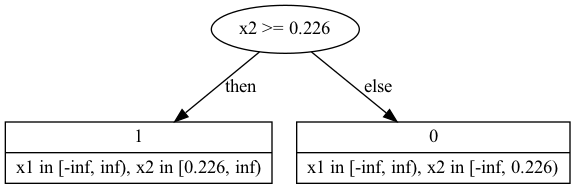

In [25]:
# Testing problem 1 solution
dtree = make_subtree(d1[-10:, :])
view_dtree(dtree)
#dtree.get_nmiss(d1[-10:, :])

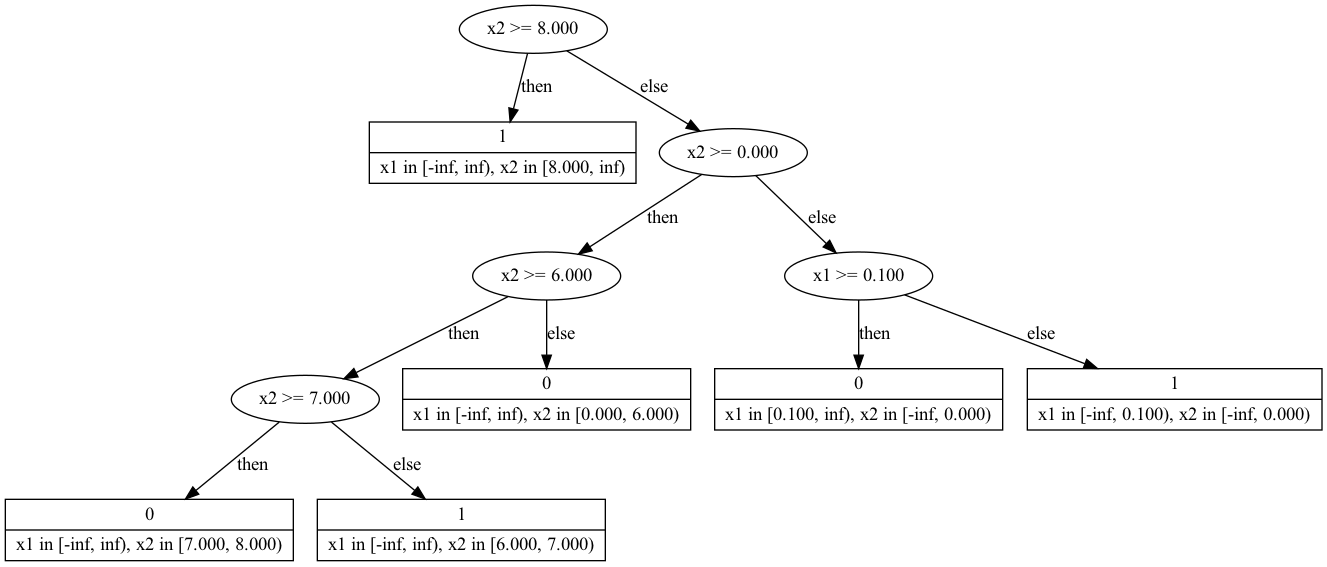

In [26]:
dtree = make_subtree(druns)
view_dtree(dtree)

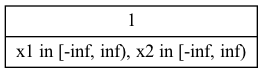

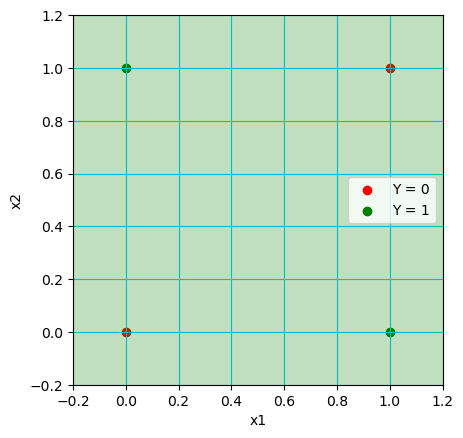

In [27]:
## Problem 2.2

# Consider x1 XOR x2
p2data = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 0]])

# Construct the decision tree
p2dtree = make_subtree(p2data)

# Plot the training data
plot_data(p2data)
# Plot the decision boundary too
plot_decision_boundary(p2dtree)

# Demonstrates that the tree only has one node
view_dtree(p2dtree)

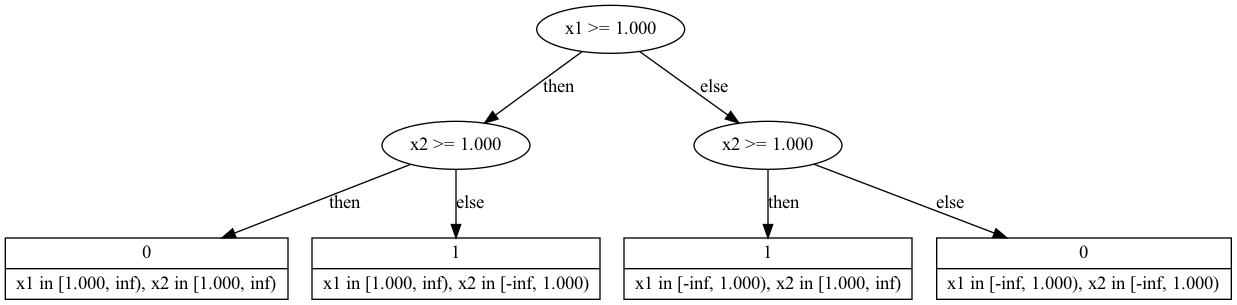

In [28]:
# Problem 2.2

# We construct a dtree explicitly

p2then_child = make_subtree(np.array([[1, 0, 1], [1, 1, 0]]))
p2else_child = make_subtree(np.array([[0, 0, 0], [0, 1, 1]]))
p2hypo = TreeNode(p2data, p2then_child, p2else_child, (0, 1))

# Build the hypothetical decision tree if we were not hindered by the first split
view_dtree(p2hypo)

In [29]:
## Problem 2.3

# List all candidate splits in j, c format
node_entropy = get_node_entropy(druns)
p3results = []
for j, c in get_candidate_splits(druns):
    # Compute then and else splits
    then_split, else_split = get_data_split(druns, j, c)

    # Find split entropy
    then_len = len(then_split)
    then_prob = then_len / len(druns)
    split_entropy = get_prob_entropy(then_prob)
    
    # Zero split entropy
    # No information gain
    if math.isclose(split_entropy, 0):
        split = j, c, 0, True
        p3results.append(split)
        continue

    # Find entropy of data after splitting
    then_entropy = get_node_entropy(then_split)
    else_entropy = get_node_entropy(else_split)
    post_split_entropy = then_prob * then_entropy + (1 - then_prob) * else_entropy
    
    gain = node_entropy - post_split_entropy
    if not math.isclose(split_entropy, 0):
        gain /= split_entropy
    
    split = j, c, round(gain * 1e3) / 1e3, False
    p3results.append(split)
    
p3results
# druns

[(0, 0.1, 0.101, False),
 (0, 0.0, 0, True),
 (1, -2.0, 0, True),
 (1, -1.0, 0.101, False),
 (1, 0.0, 0.056, False),
 (1, 1.0, 0.006, False),
 (1, 2.0, 0.001, False),
 (1, 3.0, 0.016, False),
 (1, 4.0, 0.05, False),
 (1, 5.0, 0.111, False),
 (1, 6.0, 0.236, False),
 (1, 7.0, 0.056, False),
 (1, 8.0, 0.43, False)]

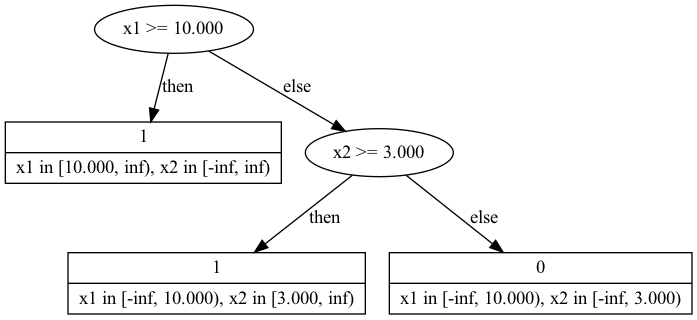

array([[10,  1,  1],
       [10,  2,  1],
       [10,  3,  1],
       [ 1,  1,  0],
       [ 1,  3,  1]])

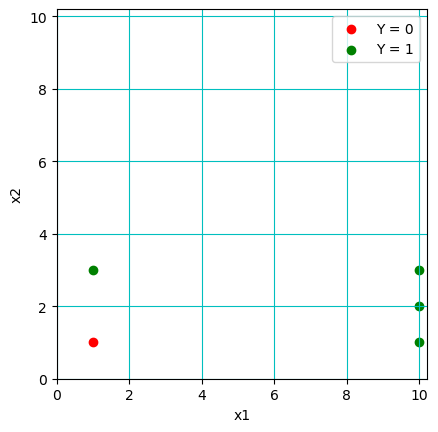

In [30]:
## Problem 2.4

d3leaves_tree = make_subtree(d3leaves)
view_dtree(d3leaves_tree)

# For debugging purposes
plot_data(d3leaves, limits=(0, 10.2))
d3leaves

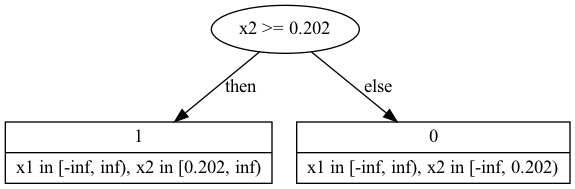

In [31]:
## Problem 2.5

d1tree = make_subtree(d1)
view_dtree(d1tree)

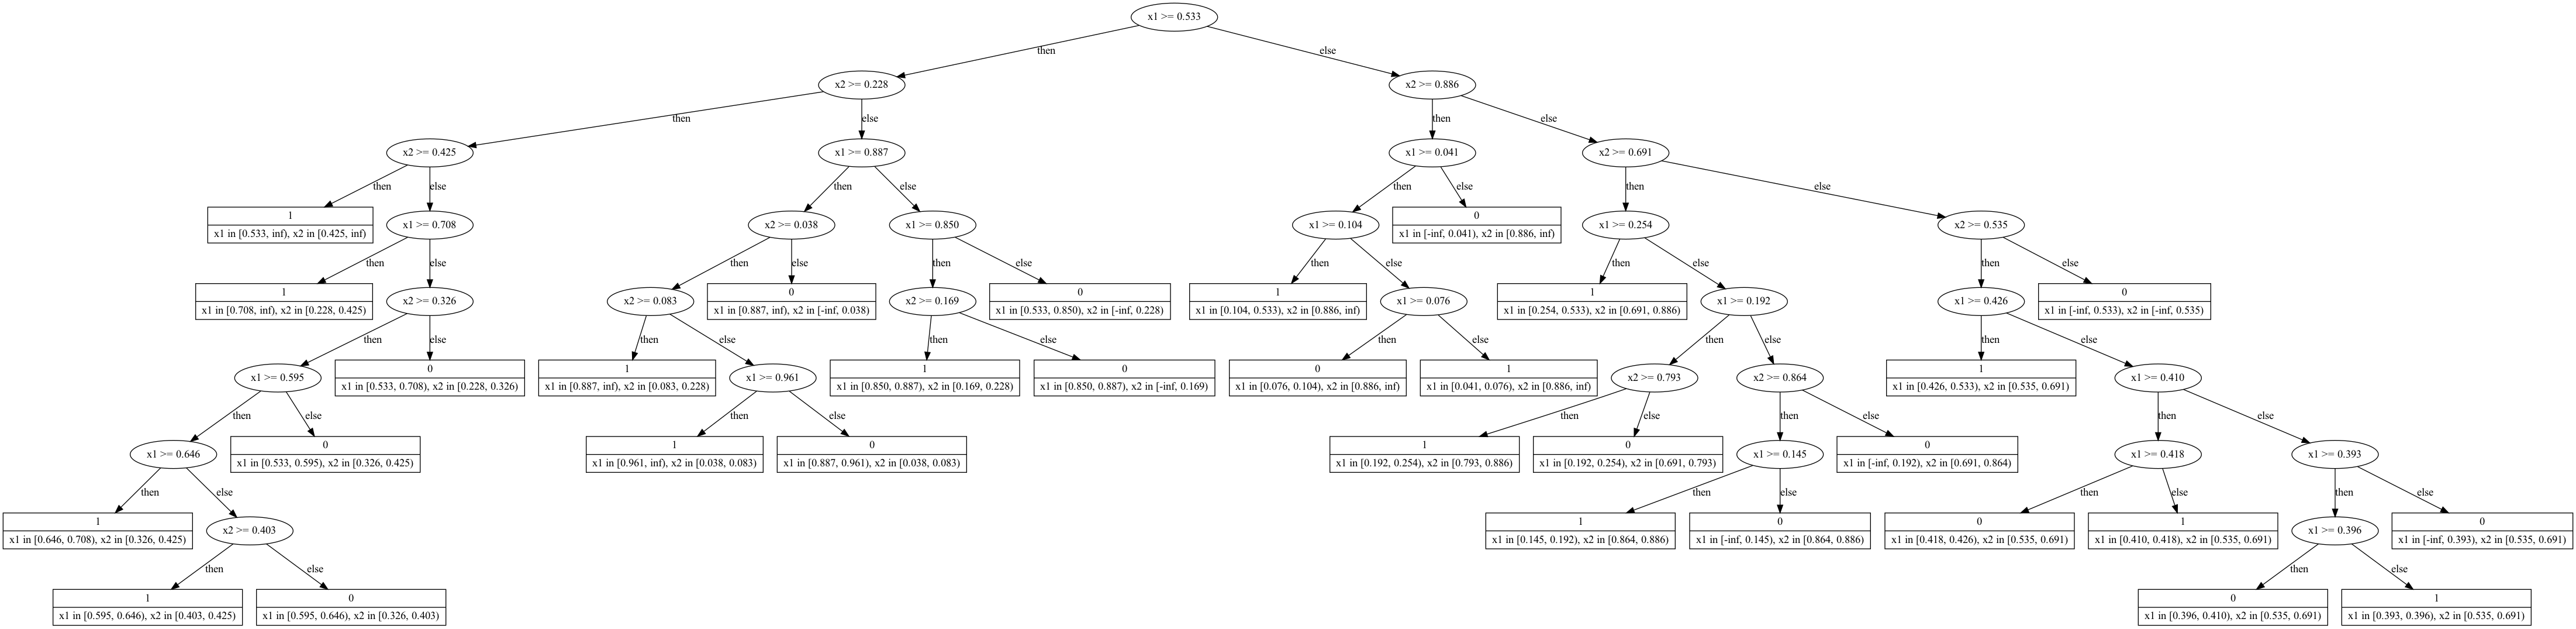

In [32]:
d2tree = make_subtree(d2)
view_dtree(d2tree)

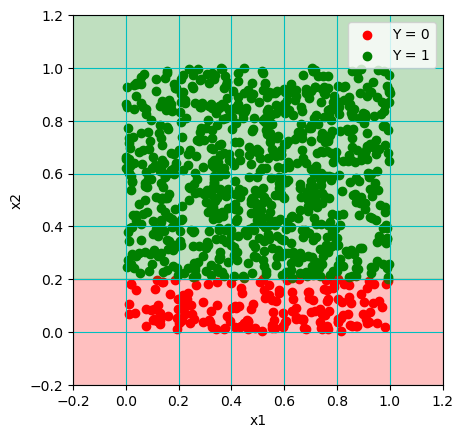

In [33]:
## Problem 2.6

# Plot the training items
plot_data(d1)

# Plot the decision boundary using d1tree
plot_decision_boundary(d1tree)

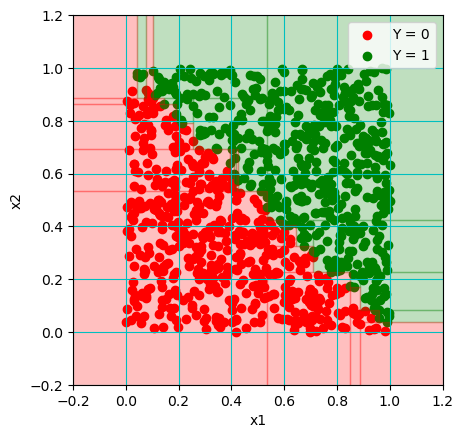

In [34]:
## Problem 2.6

# Plot the training items
plot_data(d2)

# Plot the decision boundary of d2tree
plot_decision_boundary(d2tree)

In [35]:
## Problem 2.7

In [36]:
# Shuffle the data

rng = np.random.default_rng(seed=42)
rng.shuffle(dbig)

# Split into train and test sets
train_len = 8192
train_data, test_data = dbig[:train_len], dbig[train_len:]
#plot_data(train_data, nolimit=True)

# Vary n, the number of elements in our training set
train_lens = np.array([32, 128, 512, 2048, 8192])

In [37]:
def process_nitems(n):
    trdata = train_data[:n]
    dtree = make_subtree(trdata)
    tree_size = dtree.get_size()
    nmiss = dtree.get_nmiss(test_data)
    errn = nmiss / len(test_data)
    # Part 1
    # Display n, tree_size, errn
    print(f'{n=}, {tree_size=}, {errn=:.3f}')
    # Part 3
    # Plot data
    plot_data(trdata, limits=(-2, 2))
    # Plot dtree
    plot_decision_boundary(dtree)
    return errn

n=32, tree_size=9, errn=0.078


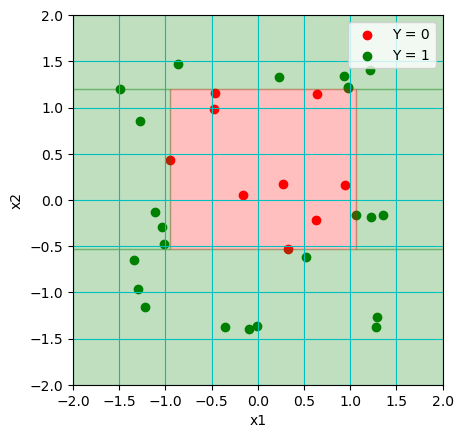

n=128, tree_size=21, errn=0.087


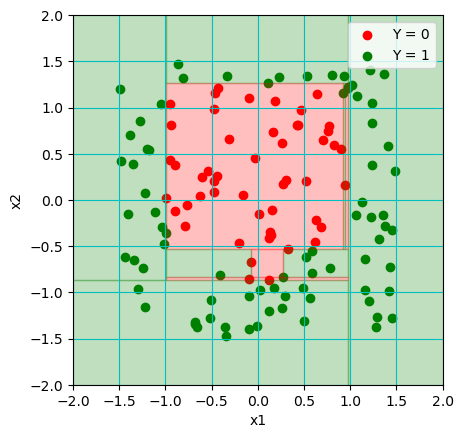

n=512, tree_size=57, errn=0.057


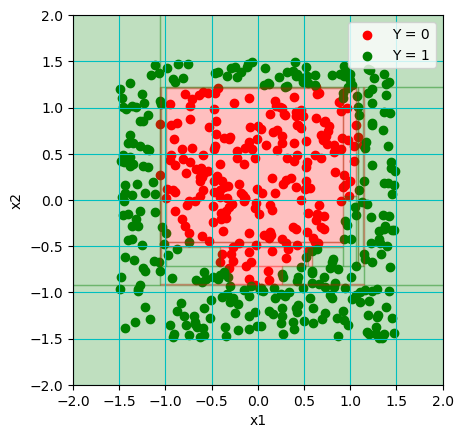

n=2048, tree_size=123, errn=0.034


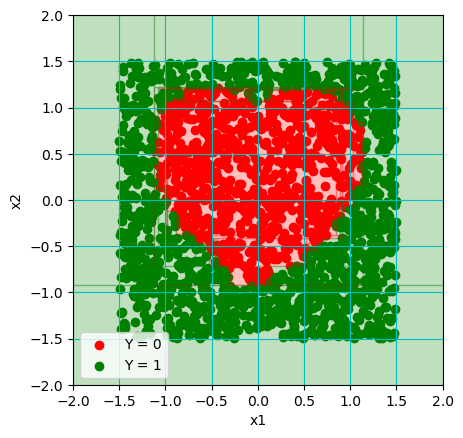

n=8192, tree_size=263, errn=0.013


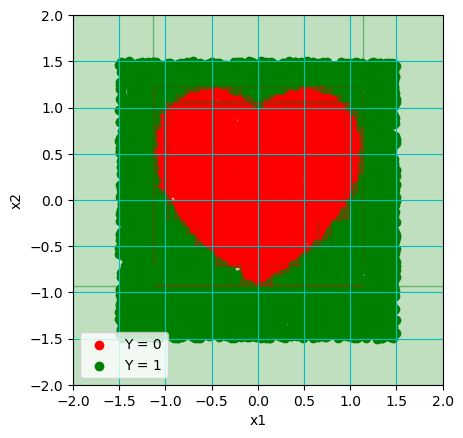

In [38]:
errns = []

for n in train_lens:
    errn = process_nitems(n)
    errns.append(errn)
    plt.show()

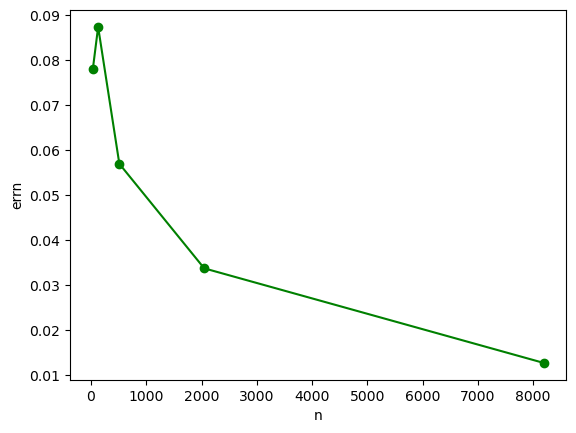

In [39]:
plt.xlabel('n')
plt.ylabel('errn')
plt.plot(train_lens, errns, 'go-')

In [40]:
## Problem 3

def process_sklearn(n):
    trdata = train_data[:n]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(trdata[:, :2], trdata[:, 2])
    nmiss = (clf.predict(test_data[:, :2]) != test_data[:, 2]).sum()
    errn = nmiss / len(test_data)
    tree_size = clf.tree_.node_count
    print(f'{n=}, {tree_size=}, {errn=:.3f}')
    return errn

n=32, tree_size=9, errn=0.076
n=128, tree_size=21, errn=0.098
n=512, tree_size=55, errn=0.051
n=2048, tree_size=107, errn=0.021
n=8192, tree_size=241, errn=0.014


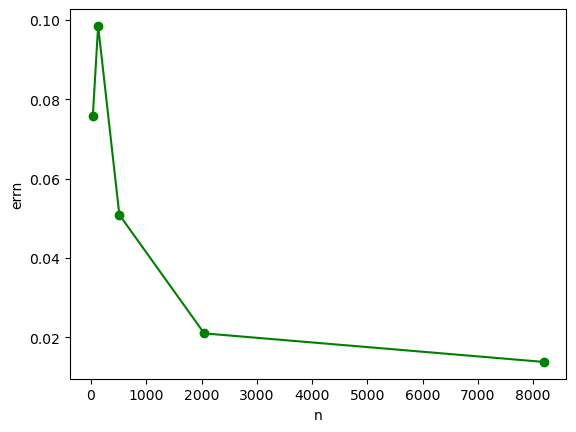

In [41]:
errns = []

for n in train_lens:
    errn = process_sklearn(n)
    errns.append(errn)
    
plt.xlabel('n')
plt.ylabel('errn')
plt.plot(train_lens, errns, 'go-')

In [46]:
## Problem 4

rng = np.random.default_rng(seed=42)
x_train_clean = rng.uniform(-np.pi, np.pi, size=100)
x_test = rng.uniform(-np.pi, np.pi, size=100)
y_test = np.sin(x_test)

(70.36600194483097, 71.03869233247751)

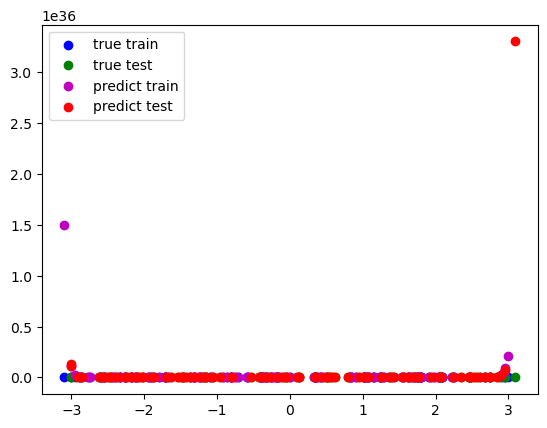

In [48]:
## Problem 4

# No noise setting

# Compute x and y for training
x_train = x_train_clean.copy()
y_train = np.sin(x_train)

# Fit using lagrange polynomial method
poly = lagrange(x_train, y_train)

# Plot the data
plt.scatter(x_train, y_train, c='b', label='true train')
plt.scatter(x_test, y_test, c='g', label='true test')
plt.scatter(x_train, poly(x_train), c='m', label='predict train')
plt.scatter(x_test, poly(x_test), c='r', label='predict test')

plt.legend()

train_error = np.log10(np.mean((y_train - poly(x_train))**2))
test_error = np.log10(np.mean((y_test - poly(x_test))**2))
train_error, test_error

In [90]:
def fit_sin(spread):
    x_train = x_train_clean.copy()

    # Add a small perturbation
    noise = rng.normal(0, spread, 100)
    x_train += noise
    
    # Comptue training y
    y_train = np.sin(x_train)
    
    
    # Fit
    poly = lagrange(x_train, y_train)
    
    # Plot data
    plt.scatter(x_train, y_train, c='b', label='true train')
    plt.scatter(x_test, y_test, c='g', label='true test')
    plt.scatter(x_train, poly(x_train), c='m', label='predict train')
    plt.scatter(x_test, poly(x_test), c='r', label='predict test')
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-1, 1)
    plt.legend()
    plt.show()
    
    train_err = np.log10(np.mean((y_train - poly(x_train))**2))
    test_err = np.log10(np.mean((y_test - poly(x_test))**2))
    return train_err, test_err

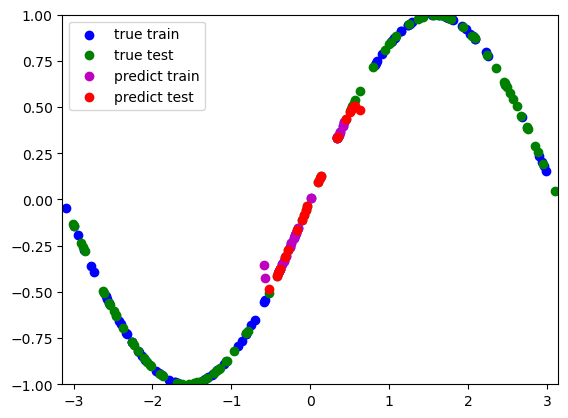

(70.36600194483097, 71.03869233247751)

In [91]:
fit_sin(0)

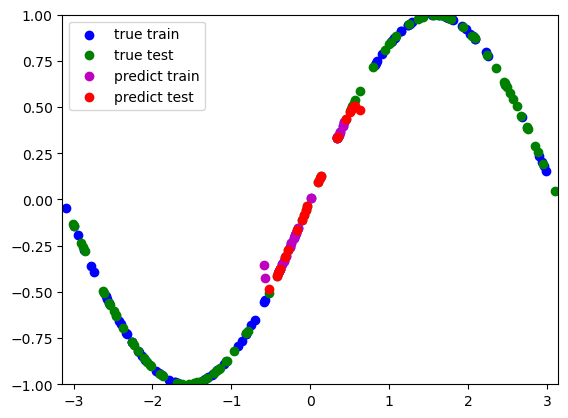

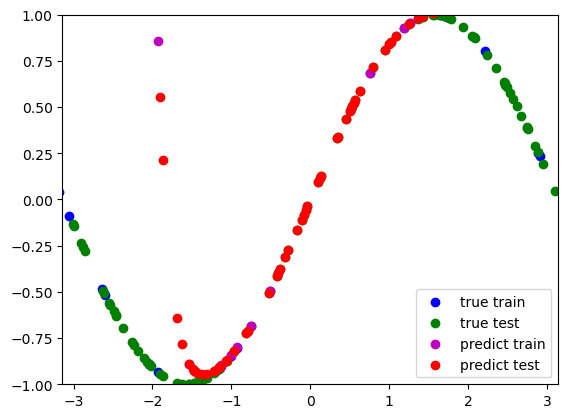

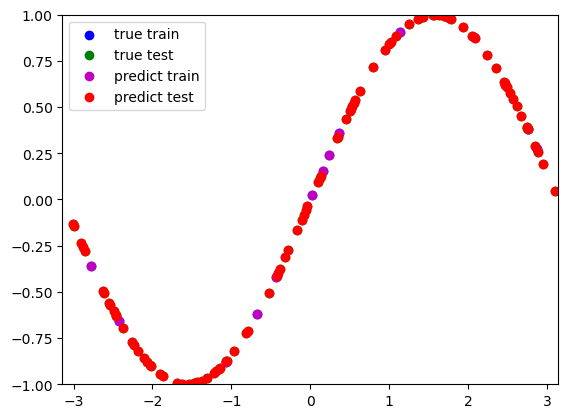

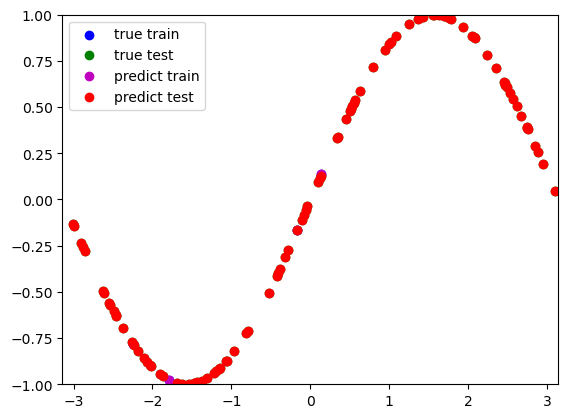

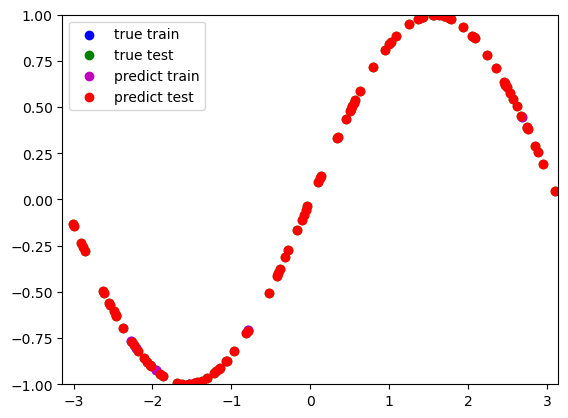

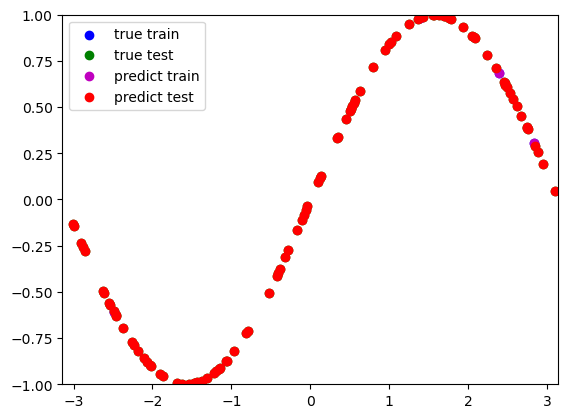

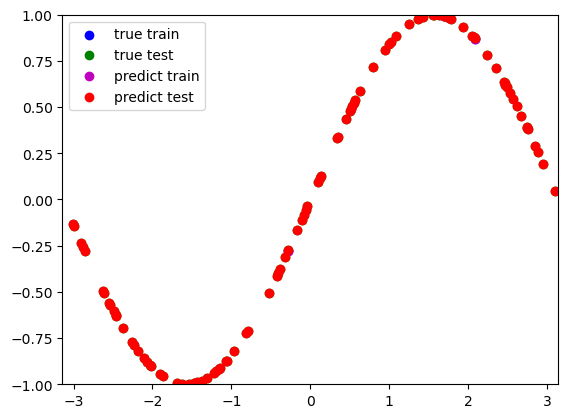

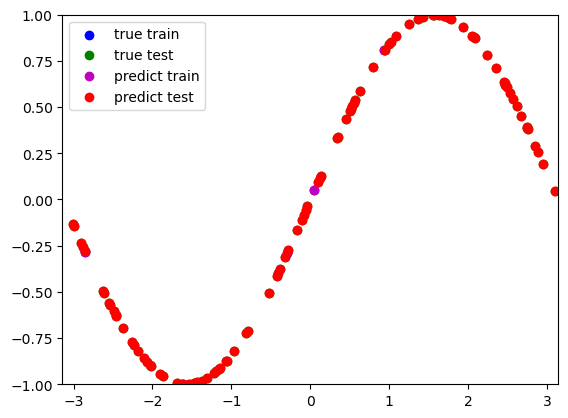

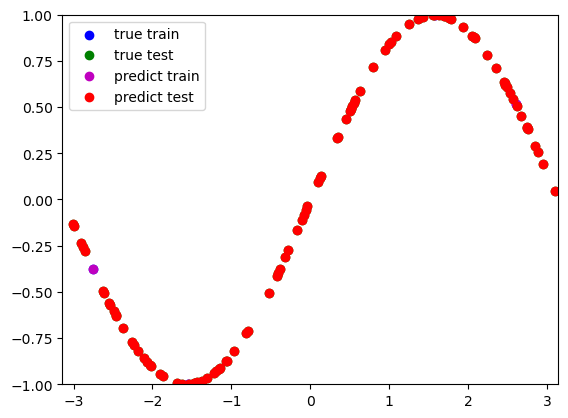

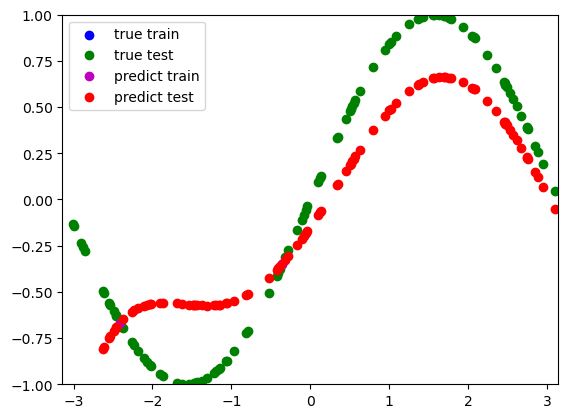

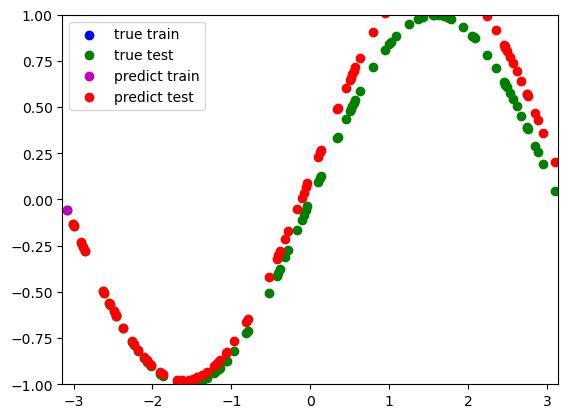

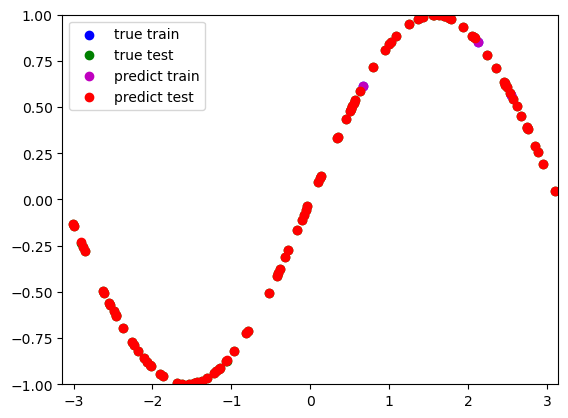

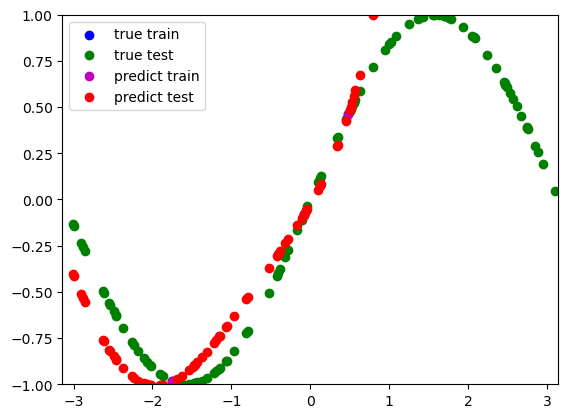

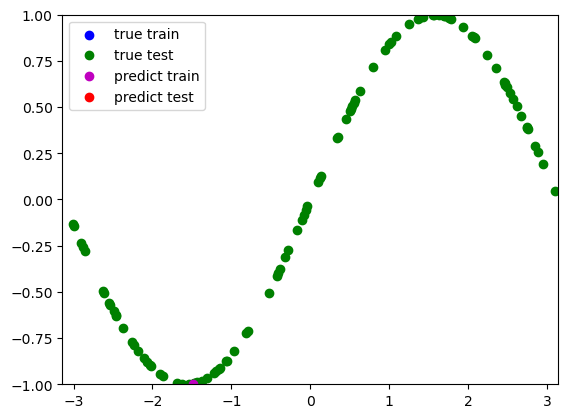

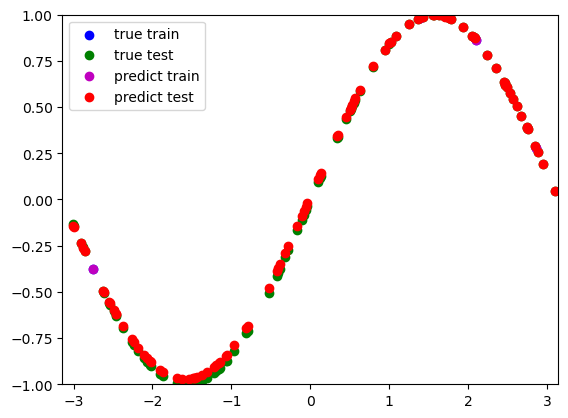

In [92]:
spreads = np.arange(0, 150, 10)
train_logerrs, test_logerrs = [], []

for spread in spreads:
    train_err, test_err = fit_sin(var)
    train_logerrs.append(train_err)
    test_logerrs.append(test_err)

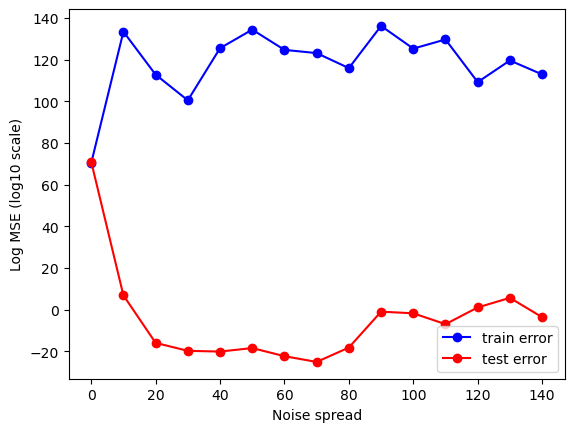

In [94]:
plt.plot(noisevars, train_logerrs, 'bo-', label='train error')
plt.plot(noisevars, test_logerrs, 'ro-', label='test error')
plt.xlabel('Noise spread (std deviation)')
plt.ylabel('Log MSE (log10 scale)')
plt.legend()